## 准备数据

In [1]:
import os
import datetime
import importlib
import torchkeras

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

printbar()


================================================================================2021-02-04 08:36:35


C:\Users\CHUN\.conda\envs\Learning\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


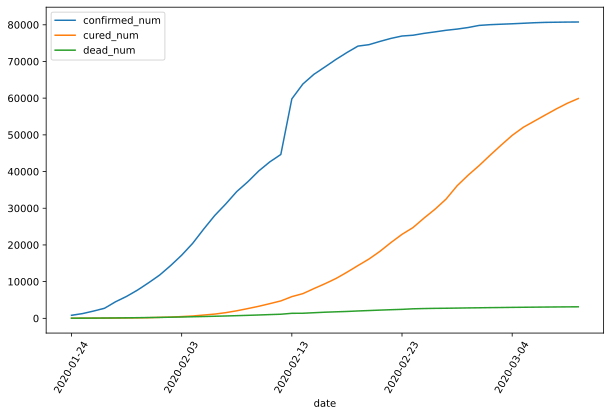

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./data/covid-19.csv', sep='\t')
df.plot(x='date', y=['confirmed_num', 'cured_num', 'dead_num'], figsize=(10, 6))
plt.xticks(rotation=60);

C:\Users\CHUN\.conda\envs\Learning\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


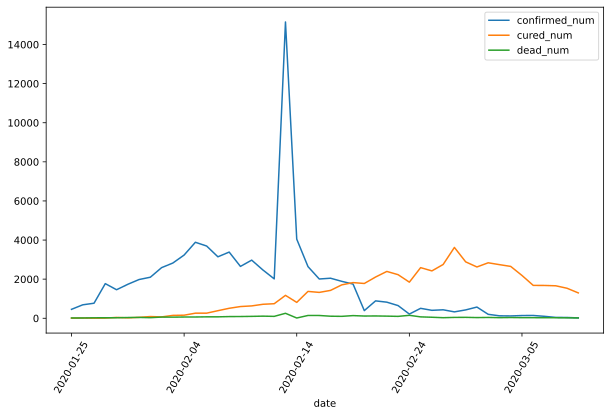

In [3]:
dfdata = df.set_index('date')
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index('date')

dfdiff.plot(x='date', y=['confirmed_num', 'cured_num', 'dead_num'], figsize=(10, 6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop('date', axis=1).astype('float32')

In [4]:
dfdiff.head()

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0


## 定义模型

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader,TensorDataset


#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

class Covid19Dataset(Dataset):

    def __len__(self):
        return len(dfdiff) - WINDOW_SIZE

    def __getitem__(self,i):
        x = dfdiff.loc[i:i+WINDOW_SIZE-1,:]
        feature = torch.tensor(x.values)
        y = dfdiff.loc[i+WINDOW_SIZE,:]
        label = torch.tensor(y.values)
        return (feature,label)

ds_train = Covid19Dataset()

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
dl_train = DataLoader(ds_train,batch_size = 38)

In [6]:
import torch
from torch import nn
import importlib
import torchkeras

torch.random.seed()

class Block(nn.Module):
    def __init__(self):
        super(Block,self).__init__()

    def forward(self,x,x_input):
        x_out = torch.max((1+x)*x_input[:,-1,:],torch.tensor(0.0))
        return x_out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3层lstm
        self.lstm = nn.LSTM(input_size = 3,hidden_size = 3,num_layers = 5,batch_first = True)
        self.linear = nn.Linear(3,3)
        self.block = Block()

    def forward(self,x_input):
        x = self.lstm(x_input)[0][:,-1,:]
        x = self.linear(x)
        y = self.block(x,x_input)
        return y

net = Net()
model = torchkeras.Model(net)
print(model)

model.summary(input_shape=(8,3),input_dtype = torch.FloatTensor)

Model(
  (net): Net(
    (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
    (linear): Linear(in_features=3, out_features=3, bias=True)
    (block): Block()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1                 [-1, 8, 3]             480
            Linear-2                    [-1, 3]              12
             Block-3                    [-1, 3]               0
Total params: 492
Trainable params: 492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000092
Forward/backward pass size (MB): 0.000229
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002197
----------------------------------------------------------------


## 训练模型

In [7]:
def mspe(y_pred,y_true):
    err_percent = (y_true - y_pred)**2/(torch.max(y_true**2,torch.tensor(1e-7)))
    return torch.mean(err_percent)

model.compile(loss_func = mspe,optimizer = torch.optim.Adagrad(model.parameters(),lr = 0.1))

In [8]:
dfhistory = model.fit(100,dl_train,log_step_freq=10)

Start Training ...

================================================================================2021-02-04 08:36:35

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   1   | 6.599 |
+-------+-------+

================================================================================2021-02-04 08:36:35

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   2   | 3.724 |
+-------+-------+

================================================================================2021-02-04 08:36:35

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   3   | 1.424 |
+-------+-------+

================================================================================2021-02-04 08:36:35

 +-------+------+
| epoch | loss |
+-------+------+
|   4   | 0.53 |
+-------+------+

================================================================================2021-02-04 08:36:35

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   5   | 0.397 |
+-------+-------+

====================

## 评估模型


In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

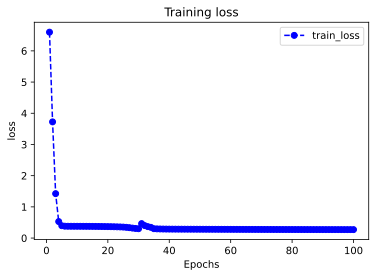

In [10]:
plot_metric(dfhistory,"loss")

In [11]:
# 使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


## 使用模型

In [12]:
# 预测此后500天的新增走势,将其结果添加到dfresult中

for i in range(500):
    arr_input = torch.unsqueeze(torch.from_numpy(dfresult.values[-38:,:]),axis=0)
    arr_predict = model.forward(arr_input)

    dfpredict = pd.DataFrame(torch.floor(arr_predict).data.numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [13]:
dfresult.query("confirmed_num==0").head()

,confirmed_num,cured_num,dead_num
50,0.0,692.0,4.0
51,0.0,608.0,3.0
52,0.0,534.0,2.0
53,0.0,469.0,1.0
54,0.0,412.0,0.0


In [14]:
dfresult.query("cured_num==0").head()

,confirmed_num,cured_num,dead_num
89,0.0,0.0,0.0
90,0.0,0.0,0.0
91,0.0,0.0,0.0
92,0.0,0.0,0.0
93,0.0,0.0,0.0


In [15]:
dfresult.query("dead_num==0").head()

,confirmed_num,cured_num,dead_num
54,0.0,412.0,0.0
55,0.0,361.0,0.0
56,0.0,316.0,0.0
57,0.0,277.0,0.0
58,0.0,243.0,0.0
